In [1]:
!nvidia-smi

Mon May 24 12:05:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   83C    P0    30W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pytorch-warmup

In [3]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-05-24 12:05:35--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa.4’

eng.testa.4         100%[===================>] 807.63K  --.-KB/s    in 0.04s   

2021-05-24 12:05:36 (17.6 MB/s) - ‘eng.testa.4’ saved [827012/827012]

--2021-05-24 12:05:36--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plai

In [4]:
!head eng.train

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [5]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

from typing import List

from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, roc_auc_score, f1_score

import pytorch_warmup as warmup

In [6]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
np.random.seed(0)  

In [7]:
def read_data(file):
    lines = open(file, "r").readlines()
    data = {"sentences": [], "labels_per_sent": []}
    sentence, labels = [], []
    for line in tqdm(lines):
        line = line.strip()
        if not line:
            if sentence and labels:
                assert len(sentence) == len(labels)
                data["sentences"].append(sentence)
                data["labels_per_sent"].append(labels)
                sentence, labels = [], []
            continue
        if line.startswith("-DOCSTART-"):
            continue
        else:
            values = line.split(" ")
            try:
                token, _, _, label = values
                sentence.append(token)
                if label != 'O':
                    labels.append(label.split('-')[-1])
                else:
                    labels.append(label)

            except Exception as e:
                print(f"Error has occur: {e}")
                continue
    return data


train = read_data("eng.train")
valid = read_data("eng.testa")

In [8]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [9]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [10]:
max_len = []

for sentence in train["sentences"]:
    max_len.append(len(sentence))
    
max_len = np.max(max_len)

In [11]:
max_len

113

In [12]:
def get_label_distribution(labels: List[List[str]]):
    labels = [label for labels_per_sent in labels for label in labels_per_sent]
    return Counter(labels)

In [13]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

Train distribution


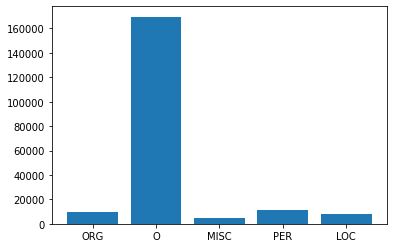

Valid distribution


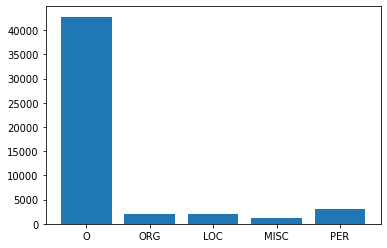

In [14]:
def visualize_distr(data: Counter):
    labels = list(data.keys())
    plt.bar(x=labels, height=list(data.values()))
    plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

In [15]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [16]:
TEXT = torchtext.legacy.data.Field(
    batch_first=True,
    lower=True,  # make lowercase
    init_token='<bos>', eos_token='<eos>'  # special tokens: beginning/end of sequence
)

In [17]:
NER = torchtext.legacy.data.Field(
    batch_first=True,
    init_token='<bos>', eos_token='<eos>'
)

In [18]:
MIN_TOKEN_FREQUENCY = 15
TEXT.build_vocab(train['sentences'], min_freq=MIN_TOKEN_FREQUENCY)  # filter out rarely occured tokens
NER.build_vocab(train['labels_per_sent'])

In [19]:
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
NER_PAD_IDX = NER.vocab.stoi[NER.pad_token]
print(f"TEXT_PAD_IDX={TEXT_PAD_IDX}, POSTAG_PAD_IDX={NER_PAD_IDX}")

TEXT_PAD_IDX=1, POSTAG_PAD_IDX=1


In [20]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(NER.vocab)
print(f"Number of unique words: {INPUT_DIM}")
print(f"Number of unique NER-tags: {OUTPUT_DIM}")
print("All NER:", ' '.join(NER.vocab.itos))

Number of unique words: 1667
Number of unique NER-tags: 9
All NER: <unk> <pad> <bos> <eos> O PER ORG LOC MISC


In [21]:
train['sentences'][0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [22]:
TEXT.vocab.stoi[train['sentences'][0][0]]

966

In [23]:
class NERDataset(Dataset):
    def __init__(self, data, TEXT, NER, max_len):
        self.text = []
        self.labels = []
        
        sentences = data['sentences']
        labels = data['labels_per_sent']
        
        for i, sentence in enumerate(sentences):
            label = labels[i]
            tokens = [token.lower() for token in sentence]
            
           
            tokens.insert(tokens.index(tokens[0]), '<bos>')
            tokens.insert(len(tokens), '<eos>')
            indices = [TEXT.vocab.stoi[token] for token in tokens]
            indices = torch.LongTensor(indices)
            padded_len = max_len - len(indices)
            indices = torch.nn.functional.pad(indices, pad=(0, padded_len), value=TEXT.vocab.stoi[TEXT.pad_token])

            label.insert(label.index(label[0]), '<bos>')
            label.insert(len(label), '<eos>')  
            indices_labels = [NER.vocab.stoi[label_] for label_ in label]
            indices_labels = torch.LongTensor(indices_labels)
            indices_labels = torch.nn.functional.pad(indices_labels, pad=(0, padded_len), value=NER.vocab.stoi[NER.pad_token])
            
            self.text.append(indices)
            self.labels.append(indices_labels)
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        return self.text[idx], self.labels[idx]

In [24]:
max_len = 128

In [25]:
train_dataset = NERDataset(train, TEXT, NER, max_len)

In [26]:
valid_dataset = NERDataset(valid, TEXT, NER, max_len)

In [27]:
batch_size = 4
train_datloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_datloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [28]:
class Attention(nn.Module):
    def __init__(self,
                 hid_dim: int,
                 num_heads: int,    
                 dropout: float):
        super(Attention, self).__init__()

        self.attention = nn.MultiheadAttention(hid_dim, num_heads)
        self.attention_layer_norm = nn.LayerNorm(hid_dim)
        self.pf_layer_norm = nn.LayerNorm(hid_dim)
        self.fc = nn.Linear(hid_dim, hid_dim)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):      
        x_ = x.permute(1, 0, 2)
        x_, _ = self.attention(x_, x_, x_, key_padding_mask=mask)
        x_ = x_.permute(1, 0, 2)
        x_ = self.dropout(x_)
        x = x + x_
        x = self.attention_layer_norm(x+x_)
        
        x = self.fc(x_)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.pf_layer_norm(x_ + x)
        return x


    
class NERModel(nn.Module):
    def __init__(self, 
                 input_dim: int=2479, 
                 hid_dim: int=256, 
                 n_layers: int=8, 
                 n_heads: int=8, 
                 dropout: float=0.1,
                 max_length: int=113,
                 padding_index: int=None,
                 output_dim: int=9):
        super(NERModel, self).__init__()
        
        self.padding_index = padding_index
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.scale = torch.nn.Parameter(torch.sqrt(torch.tensor(hid_dim, dtype=torch.float32)), requires_grad=False)
        
        self.layers = nn.ModuleList()
        
        for _ in range(n_layers):
            self.layers.append(Attention(hid_dim, n_heads, dropout))

        #self.layer_norm = nn.LayerNorm(output_dim)
        self.fc = nn.Linear(hid_dim, output_dim)
        
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, x):
        device = x.device
        bs, seq_len = x.shape[:2]
        
        if self.padding_index is not None:
            mask = x != self.padding_index
        else:
            mask = None
        
        tok_embeddings = self.tok_embedding(x) 
        positions = torch.arange(0, seq_len, device=device).repeat(bs, 1)
        pos_embeddings = self.pos_embedding(positions)
        
        x = tok_embeddings + pos_embeddings
        #x /= self.scale
        
        for layer in self.layers:
            x = layer(x, mask)

        x = self.fc(x)
        
        return x

In [29]:
input_dim = len(TEXT.vocab)
padding_index = TEXT.vocab.stoi[TEXT.pad_token]
hid_dim = 256
n_layers = 4
n_heads = 8
dropout = 0.1
output_dim = OUTPUT_DIM

In [30]:
model = NERModel(input_dim=input_dim,
                 hid_dim=hid_dim,
                 n_layers=n_layers,
                 n_heads=n_heads,
                 dropout=dropout,
                 padding_index=padding_index,
                 max_length=max_len,
                 output_dim=OUTPUT_DIM)

In [31]:
batch = next(iter(train_datloader))

In [32]:
model.forward(batch[0]).shape

torch.Size([4, 128, 9])

In [33]:
!rm -rf logs

In [34]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

path = 'logs/'
writer = SummaryWriter(log_dir=path+"/tensorboard")
best_model_path = path + 'model.pth'

warmup = 3
lambda_noam_warmup = lambda step: min((step + 1e-10) ** (-0.5), (step + 1e-10) * warmup ** (-1.5)) / 26
scheduler = None
# scheduler = ReduceLROnPlateau(optimizer, patience=8, factor=0.2, verbose=True)
# warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=2000)
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda_noam_warmup)

In [35]:
# import matplotlib.pyplot as plt
# lrs = []
# for i in range(50):
#     lrs.append(optimizer.param_groups[0]['lr'])
#     warmup_scheduler.step()
# plt.plot(list(range(50)),lrs)

In [36]:
POSTAG_PAD_IDX = 1

In [37]:
def run_epoch(model, dataloader, optimizer, criterion, lr_scheduler, warmup_scheduler, phase='train'):
    is_train = (phase == 'train')
    if is_train:
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0

    # variables for calculating accuracy
    n_predicted, n_true_predicted = 0, 0
    
    with torch.set_grad_enabled(is_train):   
        answers_true = []
        answers_pred = []
        
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            # unpack batch
            text, label = batch[0], batch[1]
            text, label = text.to(device), label.to(device)
            
            # make prediction
            pred = model.forward(text)
            #print(pred, text)
            
            # reshape prediction to [-1, output_dim]
            #pred = pred.view(-1, pred.size(-1))
            #pred = pred.argmax(-1).reshape(-1)
            pred = pred.view(-1, pred.size(-1))
            #pred = torch.tensor(pred, dtype=torch.float)
            
            # reshape gt labels to [-1, ]
            gt = label.reshape(-1)                  
            # calculate loss
            loss = criterion(pred, gt)
            
            if is_train:
                # make optimization step
                loss.backward()
                clipping_value = 3 # arbitrary value of your choosing
                clip_grad_norm_(model.parameters(), clipping_value)
                optimizer.step()
                optimizer.zero_grad()
                
            pad_idx = gt.cpu().numpy()
            pad_idx = np.where(pad_idx!=POSTAG_PAD_IDX)[0]
            
            answers_true = np.append(answers_true, gt.cpu()[pad_idx])
            answers_pred = np.append(answers_pred, pred.argmax(-1).cpu()[pad_idx]) 
                
            # calculate accuracy
            n_true_predicted += ((pred.argmax(-1) == gt) * (gt != POSTAG_PAD_IDX)).sum().item()  # exclude pad token
            n_predicted += torch.sum(gt != POSTAG_PAD_IDX).item()                
                
            epoch_loss += loss.item()
            
        answers_true, answers_pred = np.int8(answers_true), np.int8(answers_pred)
        f1 = f1_score(answers_true, answers_pred, average='weighted')
        average_loss = epoch_loss / len(dataloader)
        average_accuracy = n_true_predicted / n_predicted
        
        if phase=='val' and (warmup_scheduler is not None):
            # lr_scheduler.step()
            # lr_scheduler.step(average_loss)
            warmup_scheduler.step()
        if optimizer is not None:
            print('lr: ', optimizer.param_groups[0]['lr'])
            # for param_group in optimizer.param_groups:
            #     print('lr: ', param_group['lr'])        
        # log per-epoch metrics

        return average_loss, average_accuracy, f1

In [38]:
device = 'cuda:0'
model = model.to(device)

In [39]:
weight = torch.tensor([1, 1, 1, 1, 0.05, 1, 1, 1, 1], device=device)
criterion = nn.CrossEntropyLoss(weight=weight, ignore_index=1)

In [40]:
print(TEXT.vocab.stoi['<unk>'])
print(TEXT.vocab.stoi['<bos>'])
print(TEXT.vocab.stoi['<eos>'])
print(TEXT.vocab.stoi['<pad>'])
print(NER.vocab.stoi['O'])
print(NER.vocab.stoi['PER'])
print(NER.vocab.stoi['ORG'])
print(NER.vocab.stoi['LOC'])
print(NER.vocab.stoi['MISC'])

0
2
3
1
4
5
6
7
8


In [41]:
warmup_scheduler.step()
optimizer.param_groups[0]['lr']

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.00037009632644061595

In [42]:
n_epochs = 50
best_val_loss = float('+inf')

# with torch.autograd.detect_anomaly():
for epoch in range(n_epochs):
    train_loss, train_accuracy, train_f1 = run_epoch(model, train_datloader, optimizer, criterion, scheduler, warmup_scheduler, phase='train')
    val_loss, val_accuracy, val_f1 = run_epoch(model, valid_datloader, None, criterion, scheduler, warmup_scheduler, phase='val')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train accuracy: {train_accuracy * 100:.2f} | Train F1: {train_f1 * 100:.2f}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. accuracy: {val_accuracy * 100:.2f} | Val F1: {val_f1 * 100:.2f}')

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)
    writer.add_scalar('F1/train', train_f1, epoch)
    writer.add_scalar('F1/val', val_f1, epoch)
    
    writer.flush()


lr:  0.00037009632644061595



Epoch: 01
	Train Loss: 1.875 | Train accuracy: 24.00 | Train F1: 30.61
	 Val. Loss: 1.666 |  Val. accuracy: 8.34 | Val F1: 4.21



lr:  0.0007401926528442222



Epoch: 02
	Train Loss: 1.779 | Train accuracy: 31.91 | Train F1: 38.81
	 Val. Loss: 1.847 |  Val. accuracy: 42.13 | Val F1: 48.60



lr:  0.001110288979192314



Epoch: 03
	Train Loss: 1.765 | Train accuracy: 26.06 | Train F1: 32.76
	 Val. Loss: 1.616 |  Val. accuracy: 58.77 | Val F1: 60.05



lr:  0.0009615384615264425



Epoch: 04
	Train Loss: 1.672 | Train accuracy: 30.95 | Train F1: 37.73
	 Val. Loss: 1.900 |  Val. accuracy: 5.62 | Val F1: 1.02


KeyboardInterrupt: ignored